Epoch 1, Loss: 0.1837
Epoch 2, Loss: 0.1307
Epoch 3, Loss: 0.0942
Epoch 4, Loss: 1.0052
Epoch 5, Loss: 0.9901
Epoch 6, Loss: 0.9942
Epoch 7, Loss: 0.9729
Epoch 8, Loss: 0.9972
Epoch 9, Loss: 0.9977
Epoch 10, Loss: 0.8792
Epoch 11, Loss: 0.9678
Epoch 12, Loss: 0.8861
Epoch 13, Loss: 0.9980
Epoch 14, Loss: 0.9975
Epoch 15, Loss: 0.9941


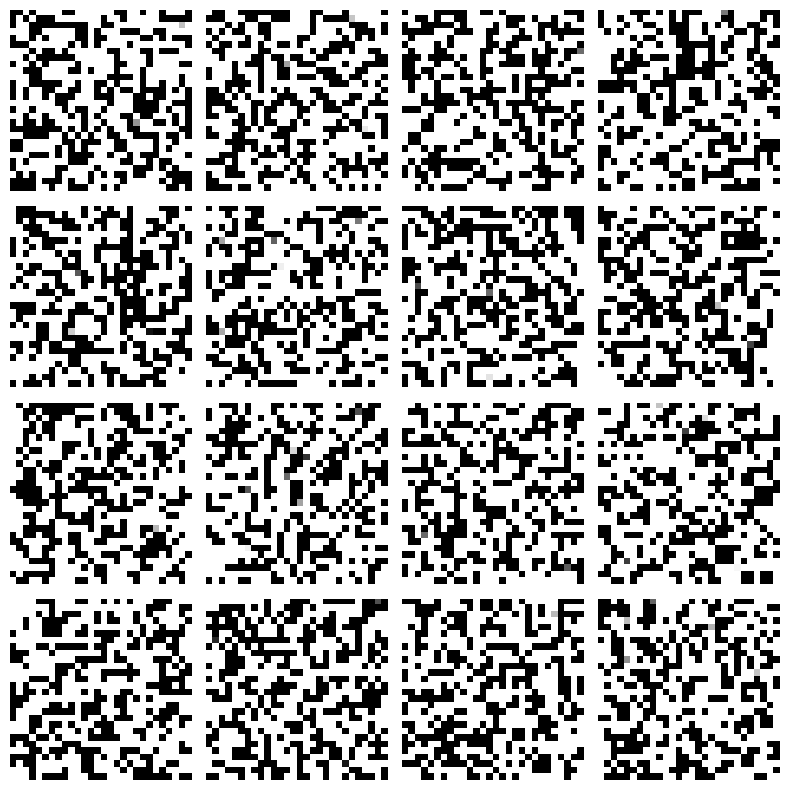

In [ ]:
### All-in-one CUDA-aware DDPM Training & Generation on MNIST

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simple UNet for MNIST + time embedding
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_embed = nn.Sequential(nn.Linear(1, 64), nn.ReLU())
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 1, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        t = t.float().view(-1, 1)
        t_embed = self.time_embed(t).view(-1, 64, 1, 1)
        x = self.relu(self.conv1(x) + t_embed)
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        return x
        # return self.conv4(x)

# Diffusion process
class Diffusion:
    def __init__(self, T=1000, beta_start=1e-4, beta_end=0.02, device="cpu"):
        self.T = T
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, T).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward(self, x0, t):
        noise = torch.randn_like(x0).to(self.device)
        alpha_bar = self.alpha_bars[t].view(-1, 1, 1, 1).to(self.device)
        xt = torch.sqrt(alpha_bar) * x0 + torch.sqrt(1 - alpha_bar) * noise
        return xt, noise

# Initialize
model = SimpleUNet().to(device)
diffusion = Diffusion(T=1000, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)  # [-1, 1] scaling
])
dataset = datasets.MNIST(root="data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Training
for epoch in range(0):
    for x0, _ in dataloader:
        x0 = x0.to(device)
        t = torch.randint(0, diffusion.T, (x0.shape[0],)).to(device)
        xt, noise = diffusion.forward(x0, t)
        pred_noise = model(xt, t)
        loss = F.mse_loss(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# Sampling
def generate_samples(model, diffusion, num_samples=16, device="cpu"):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 1, 28, 28).to(device)
        for t in reversed(range(diffusion.T)):
            t_tensor = torch.full((num_samples,), t, dtype=torch.long).to(device)
            pred_noise = model(x, t_tensor)

            alpha_t = diffusion.alphas[t]
            alpha_bar_t = diffusion.alpha_bars[t]
            beta_t = diffusion.betas[t]

            mean = (x - (beta_t / torch.sqrt(1 - alpha_bar_t)) * pred_noise) / torch.sqrt(alpha_t)
            noise = torch.randn_like(x).to(device) if t > 0 else 0
            x = mean + torch.sqrt(beta_t) * noise

        x = (x + 1) / 2  # [-1, 1] to [0, 1]
        x = torch.clamp(x, 0, 1).cpu().numpy()
        return x

# Generate and plot
samples = generate_samples(model, diffusion, num_samples=16, device=device)
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].squeeze(), cmap="gray")
    ax.axis("off")
plt.tight_layout()
plt.show()
